In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [5]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [6]:
from model_PyG import *
from utils import *

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [8]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [9]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_attr))

### Setup

In [10]:
dataset = "deybis_05" # "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
encoder = "GIN" # Change GIN, GINE
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100
elif (dataset in ["deybis_05", "vanessa_05"]):
	train_set = [
		# "FrescoAmazonas_1", "FrescoAmazonas_2",
		# "FrescoCusco_1", "FrescoCusco_2",
		# "FrescoSanMartin_1", "FrescoSanMartin_2",
		# "SecoAmazonas_1", "SecoAmazonas_2",
		# "SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)
edge_attr = torch.tensor([
	[0.5, 1.0], 
	[0.5, 1.0], 
	[1.0, 1.5], 
	[1.0, 1.5]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

print(data)
info(data)

transform = T.Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

data = transform(data)
print(data)
info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [11]:
# Only for GIN
""" transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

In [12]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		edge_attr = torch.ones((edge_index.size(1), 1)) # Only for test GINE

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		info(data)

		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["deybis_05", "vanessa_05", "mentos_05"]: # Change
	features = [0, 1, 2, 4, 5]

	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, 0, 1, 2, ...

		df_intensity = df_nodes.iloc[:, 4:]
		# 0, 1, 2, ...

		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup

		# Node features
		""" mz = np.log10(df_nodes["mz"].values + 1e-8) # Log-transform m/z to stabilize scale differences
		rt = df_nodes["rt"].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8) # Z-score normalization for retention time (RT)

		intensity = df_intensity.values.astype(np.float32)
		intensity = intensity / (intensity.sum(axis=0, keepdims=True) + 1e-8)
		intensity_mean = intensity.mean(axis=1)

		intensity_std = intensity.std(axis=1)
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		intensity_cv = np.log1p(np.clip(intensity_cv, 0, 2.0))

		presence_ratio = (df_intensity > 0).mean(axis=1) # Acts as a reliability / confidence signal """

		# df_intensity = np.sign(df_intensity) * np.log10(np.abs(df_intensity) + 1e-8)

		mz = np.log10(df_nodes.iloc[:, 2].values + 1e-8)
		rt = df_nodes.iloc[:, 3].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8)
		intensity_mean = df_intensity.mean(axis=1).values
		intensity_std = df_intensity.std(axis=1).values
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		presence_ratio = (df_intensity > 0).mean(axis=1)

		x = np.stack([
				mz,             			# 0 physicochemical identity
				rt,							# 1 chromatographic alignment
				np.log10(intensity_mean + 1e-8), 	# 2 global abundance
				intensity_std,  			# 3
				intensity_cv,   			# 4 robustness (anti-oversmoothing)
				presence_ratio  			# 5 reliability
			], axis=1)

		x = torch.tensor(x[:, features], dtype=torch.float) # [N, F]
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		# Edge index
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values.T, dtype=torch.long) # [2, E]

		# Edge attribute
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]

		# edge_attr = edge_weight.view(-1, 1) # [E,1]
		edge_attr = torch.stack([
							edge_weight.abs(),        # strength
							torch.sign(edge_weight),  # direction (+1, -1)
							edge_weight ** 2          # nonlinearity
						], dim=1) # [E, 3]

		# Reduce number of edges
		""" mask = torch.abs(edge_weight) > 0.95
		edge_index = edge_index[:, mask]
		edge_attr  = edge_attr[mask] """

		data = Data(x=x, edge_index=edge_index.contiguous(), edge_attr=edge_attr)

		data = transform(data)
		# data = data.to(device)

		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 2069
Num. edges:	 2854123
Num. features:	 5
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 2066, 2067, 2068],
        [   1,    2,    3,  ..., 2066, 2067, 2068]], device='cuda:1')
tensor([[ 2.2041, -1.3880,  4.6579,  0.2162,  1.0000],
        [ 2.4736, -1.3861,  3.5424,  0.3672,  1.0000],
        [ 2.4911, -1.3845,  3.4646,  0.5512,  1.0000],
        ...,
        [ 1.8638,  1.3861,  6.6725,  0.3077,  1.0000],
        [ 2.5329,  1.4843,  5.8094,  0.4383,  1.0000],
        [ 1.9194,  1.5903,  6.1933,  0.4805,  1.0000]], device='cuda:1')
tensor([[ 0.5237, -1.0000,  0.2743],
        [ 0.9126,  1.0000,  0.8329],
        [ 0.8478,  1.0000,  0.7187],
        ...,
        [ 0.8204, -0.0351,  0.6972],
        [ 0.8206,  0.0358,  0.6975],
        [ 0.8209, -0.0366,  0.6979]], device='cuda:1')
Validate:	 True
Num. nodes:	 2071
Num. edges:	 2891409
Num. features:	 5
Has isolated:

In [13]:
train_loader

{'SecoSanMartin_1': Data(x=[2069, 5], edge_index=[2, 2854123], edge_attr=[2854123, 3]),
 'SecoSanMartin_2': Data(x=[2071, 5], edge_index=[2, 2891409], edge_attr=[2891409, 3])}

### Train

In [14]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [15]:
def fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]

			# Encoder
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
				# z = F.normalize(z, dim=1)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)

			# Positive edges
			pos_edge_index = data.edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=data.edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)
			dict_node_embeddings[ts] = z.cpu().numpy()

	del loss, z
	# torch.cuda.synchronize()
	torch.cuda.empty_cache()
	
	return dict_node_embeddings, list_loss

In [16]:
train_set

['SecoSanMartin_1', 'SecoSanMartin_2']

In [17]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

if encoder == "GIN":
	model = TGAE_GIN(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)
elif encoder == "GINE":
	edge_dim = train_loader[train_set[0]].edge_attr.size(1)

	model = TGAE_GINE(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size, edge_dim).to(device)

print("Generating training features")
print("Fitting model")
print(encoder, dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
GIN deybis_05 0.0001 100 5 128 2


Epoch: 86:  85%|████████▌ | 85/100 [08:25<01:29,  5.95s/it, Loss: 0.6339]


Stopping early as no improvement has been observed.
Early stopping at epoch 86


### Get embeddings

In [18]:
dict_node_embeddings

{'SecoSanMartin_1': array([[ 0.07314863, -0.04163478,  0.04490227, ..., -0.08562464,
         -0.11014611,  0.22104546],
        [ 0.07357042, -0.02781035,  0.04513337, ..., -0.08344567,
         -0.07873236,  0.28366923],
        [ 0.0688854 , -0.02422646,  0.05112097, ..., -0.07961605,
         -0.06653903,  0.27833983],
        ...,
        [ 0.02481782, -0.05464793,  0.05860821, ..., -0.06321686,
         -0.02372244,  0.07697699],
        [ 0.03627997, -0.05096676,  0.07030685, ..., -0.08212822,
         -0.01653395,  0.10813244],
        [ 0.01729287, -0.04540348,  0.06085723, ..., -0.05523523,
          0.00849167,  0.10011895]], dtype=float32),
 'SecoSanMartin_2': array([[ 0.07535157, -0.04173577,  0.04059421, ..., -0.08663305,
         -0.11252958,  0.23356628],
        [ 0.06985589, -0.01525322,  0.0438594 , ..., -0.07619195,
         -0.04775397,  0.33410287],
        [ 0.0737226 , -0.05090559,  0.04306201, ..., -0.08748497,
         -0.13243051,  0.18392122],
        ...,
 

### Plot

In [19]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(4140, 128)


array([[ 0.07314863, -0.04163478,  0.04490227, ..., -0.08562464,
        -0.11014611,  0.22104546],
       [ 0.07357042, -0.02781035,  0.04513337, ..., -0.08344567,
        -0.07873236,  0.28366923],
       [ 0.0688854 , -0.02422646,  0.05112097, ..., -0.07961605,
        -0.06653903,  0.27833983],
       ...,
       [ 0.0312817 , -0.04903791,  0.06604975, ..., -0.07823017,
         0.00452289,  0.11973132],
       [ 0.03324122, -0.04581821,  0.05720908, ..., -0.07640669,
         0.00955502,  0.1536002 ],
       [ 0.03279019, -0.04807839,  0.06146871, ..., -0.07818569,
         0.0056097 ,  0.13588461]], dtype=float32)

In [20]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
	labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

4140
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
list_loss

[3.4047746658325195,
 5.575969696044922,
 0.8988854885101318,
 1.456557273864746,
 0.8621530532836914,
 0.670151948928833,
 0.8139258623123169,
 0.6874272227287292,
 0.6667395830154419,
 0.6880035400390625,
 0.6549142599105835,
 0.6441832780838013,
 0.650438666343689,
 0.6577394604682922,
 0.6446664333343506,
 0.6395115852355957,
 0.6393065452575684,
 0.6422012448310852,
 0.6411305665969849,
 0.6377217769622803,
 0.6375560760498047,
 0.6371498107910156,
 0.6380711793899536,
 0.6379877328872681,
 0.6366642713546753,
 0.6366912722587585,
 0.6364443302154541,
 0.636365532875061,
 0.636653482913971,
 0.6360616087913513,
 0.6358492374420166,
 0.635844886302948,
 0.6355319023132324,
 0.6356191635131836,
 0.6355036497116089,
 0.6352192759513855,
 0.6352657675743103,
 0.6350740790367126,
 0.6350092887878418,
 0.6350167393684387,
 0.6348118782043457,
 0.6348395347595215,
 0.634731650352478,
 0.6346756219863892,
 0.6346781253814697,
 0.6345540285110474,
 0.6345778107643127,
 0.6344859600067139,


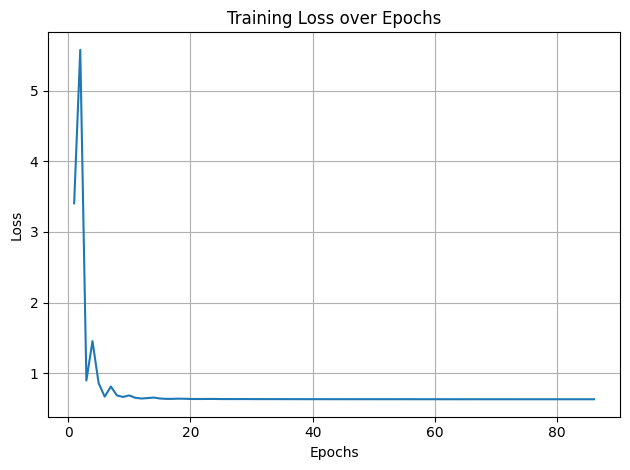

In [22]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.savefig(f"data/{dataset}/output/plot/loss_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

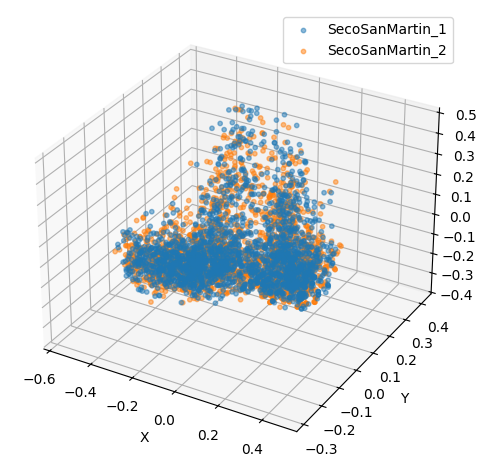

In [23]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

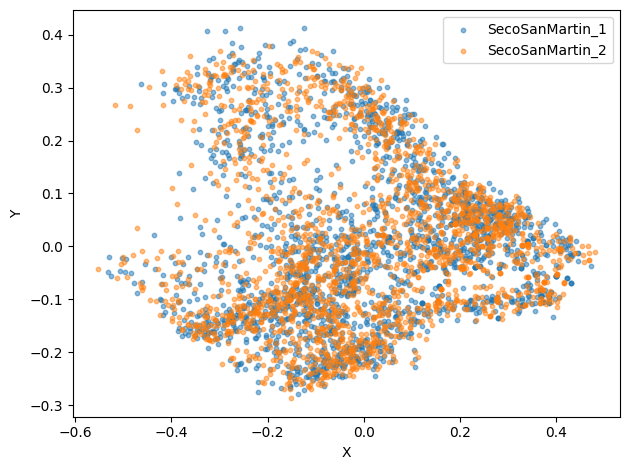

In [24]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.savefig(f"data/{dataset}/output/plot/node_embeddings_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Similarity analysis (KNN)

In [25]:
train_set

['SecoSanMartin_1', 'SecoSanMartin_2']

In [26]:
# Get node ids

dict_node_id = {}

if dataset in ["deybis_05", "vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
	for ts in train_set:
		dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'SecoSanMartin_1': array([   0,    1,    5, ..., 1829, 1869, 1920]),
 'SecoSanMartin_2': array([   0,    3,    4, ..., 2063, 2064, 2070])}

In [27]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,SecoSanMartin_1,SecoSanMartin_2
0,0,34
1,1,167
2,5,71
3,9,103
4,10,10
...,...,...
2064,1595,1720
2065,1670,1718
2066,1829,1818
2067,1869,1854


In [28]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

SecoSanMartin_1 SecoSanMartin_2


,SecoSanMartin_1,SecoSanMartin_2
4,10,10
42,66,66
82,129,129
101,154,154
108,166,166
...,...,...
2023,1963,1963
2029,1991,1991
2032,1999,1999
2033,2009,2009


In [29]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

257


,SecoSanMartin_1,SecoSanMartin_2
4,10,10
42,66,66
82,129,129
101,154,154
108,166,166
...,...,...
2023,1963,1963
2029,1991,1991
2032,1999,1999
2033,2009,2009


In [30]:
# Comparison (with test_pairs)

if dataset not in ["deybis_05", "vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [31]:
common_node_id = df_node_alignment_filter.iloc[:, 0].values
common_node_id

array([  10,   66,  129,  154,  166,  180,  224,  241,  261,  267,  305,
        315,  336,  344,  348,  369,  375,  381,  387,  389,  400,  413,
        423,  435,  439,  461,  464,  468,  470,  473,  480,  489,  513,
        530,  555,  564,  570,  584,  586,  597,  600,  653,  657,  672,
        679,  696,  701,  702,  704,  705,  709,  713,  731,  746,  770,
        773,  785,  797,  804,  808,  809,  842,  878,  881,  889,  893,
        912,  915,  919,  932,  963,  965,  968,  989,  999, 1004, 1007,
       1107, 1108, 1146, 1158, 1166, 1173, 1191, 1196, 1229, 1239, 1249,
       1250, 1253, 1273, 1281, 1293, 1303, 1309, 1321, 1343, 1345, 1348,
       1354, 1355, 1357, 1375, 1376, 1378, 1409, 1432, 1438, 1443, 1444,
       1445, 1461, 1477, 1482, 1486, 1497, 1504, 1508, 1519, 1557, 1585,
       1596, 1608, 1610, 1621, 1646, 1657, 1660, 1672, 1692, 1709, 1731,
       1742, 1743, 1758, 1771, 1796, 1807, 1809, 1810, 1819, 1833, 1834,
       1839, 1849, 1850, 1854, 1871, 1880, 1940, 19

In [32]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,secoAmazonas_1.1,secoAmazonas_1.2,secoAmazonas_1.3,secoAmazonas_2.1,secoAmazonas_2.2,secoAmazonas_2.3,secoSanMartin_1.1,...,frescoSanMartin_1.3,frescoSanMartin_2.1,frescoSanMartin_2.2,frescoSanMartin_2.3,frescoCusco_1.1,frescoCusco_1.2,frescoCusco_1.3,frescoCusco_2.1,frescoCusco_2.2,frescoCusco_2.3
0,6.068,159.99556,Unknown,7034,12640,65221,32286,31628,31905,56633,...,15145,18282,10914,26094,42867,24209,23077,23381,34669,18614
1,6.082,297.61154,Unknown,5804,1868,1770,3586,5184,2190,4624,...,2326,3384,3997,1552,7336,18067,5962,3464,2824,1454
2,6.083,56.07626,Unknown,1858616,1355594,784461,1604749,961531,429947,1198564,...,409343,656599,695987,948623,1176033,725797,902930,1096845,981074,1652615
3,6.085,372.91318,Unknown,889,3744,1426,1595,5618,962,4560,...,638,130,2584,560,3172,1308,1437,678,384,884
4,6.094,105.08218,Unknown,161839,185789,177707,247117,199642,320656,185514,...,173261,192259,162352,110494,199205,201648,123379,273539,311499,109671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,30.910,207.07442,Unknown,1920648,8111189,8083258,6209147,6025864,8220973,6065002,...,7133145,4591789,11557840,5309830,5683446,4647045,5244320,5169784,7616534,5619936
2068,30.917,267.05429,Unknown,253837,416976,1197517,729570,454698,800359,805001,...,677529,1484993,687616,433578,264383,774951,716534,942853,536187,466975
2069,30.929,177.12947,Unknown,191337,470834,678833,342612,780480,446188,801031,...,593265,482997,297340,304800,481632,634510,519560,277466,624171,576706
2070,30.929,341.03875,Unknown,252353,226004,326926,298564,455367,519420,373994,...,471136,746013,272351,323189,285329,447152,685025,672340,523839,859197


In [33]:
print(len(common_node_id), len(df_join_raw))

257 2072


In [34]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment_{encoder}_{dataset}_{train_set}.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
10,6.101,248.97993,Unknown
66,6.254,302.70784,Unknown
129,6.468,68.02769,Unknown
154,6.564,120.02531,Unknown
166,6.647,86.10524,Unknown
...,...,...,...
1963,29.116,429.07242,Unknown
1991,29.549,535.05153,Unknown
1999,29.740,267.06174,Unknown
2009,29.894,341.12805,Unknown


In [35]:
# Comparison (sta vs Vanessa)

""" list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match) """

' list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]\n\nmatch = set(list_node_id_sta) & set(common_node_id)\nprint(train_set)\nprint(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")\nprint(f"Match comp: {len(match)}/{len(list_node_id_sta)}")\nprint(match) '

### Clustering analysis

In [36]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,secoAmazonas_1.1,secoAmazonas_1.2,secoAmazonas_1.3,secoAmazonas_2.1,secoAmazonas_2.2,secoAmazonas_2.3,secoSanMartin_1.1,...,frescoSanMartin_1.3,frescoSanMartin_2.1,frescoSanMartin_2.2,frescoSanMartin_2.3,frescoCusco_1.1,frescoCusco_1.2,frescoCusco_1.3,frescoCusco_2.1,frescoCusco_2.2,frescoCusco_2.3
0,6.068,159.99556,Unknown,7034,12640,65221,32286,31628,31905,56633,...,15145,18282,10914,26094,42867,24209,23077,23381,34669,18614
1,6.082,297.61154,Unknown,5804,1868,1770,3586,5184,2190,4624,...,2326,3384,3997,1552,7336,18067,5962,3464,2824,1454
2,6.083,56.07626,Unknown,1858616,1355594,784461,1604749,961531,429947,1198564,...,409343,656599,695987,948623,1176033,725797,902930,1096845,981074,1652615
3,6.085,372.91318,Unknown,889,3744,1426,1595,5618,962,4560,...,638,130,2584,560,3172,1308,1437,678,384,884
4,6.094,105.08218,Unknown,161839,185789,177707,247117,199642,320656,185514,...,173261,192259,162352,110494,199205,201648,123379,273539,311499,109671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,30.910,207.07442,Unknown,1920648,8111189,8083258,6209147,6025864,8220973,6065002,...,7133145,4591789,11557840,5309830,5683446,4647045,5244320,5169784,7616534,5619936
2068,30.917,267.05429,Unknown,253837,416976,1197517,729570,454698,800359,805001,...,677529,1484993,687616,433578,264383,774951,716534,942853,536187,466975
2069,30.929,177.12947,Unknown,191337,470834,678833,342612,780480,446188,801031,...,593265,482997,297340,304800,481632,634510,519560,277466,624171,576706
2070,30.929,341.03875,Unknown,252353,226004,326926,298564,455367,519420,373994,...,471136,746013,272351,323189,285329,447152,685025,672340,523839,859197


In [37]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:] # Important two last column no only to Mentos 3:-2
df_join_raw_signal

,secoAmazonas_1.1,secoAmazonas_1.2,secoAmazonas_1.3,secoAmazonas_2.1,secoAmazonas_2.2,secoAmazonas_2.3,secoSanMartin_1.1,secoSanMartin_1.2,secoSanMartin_1.3,secoSanMartin_2.1,...,frescoSanMartin_1.3,frescoSanMartin_2.1,frescoSanMartin_2.2,frescoSanMartin_2.3,frescoCusco_1.1,frescoCusco_1.2,frescoCusco_1.3,frescoCusco_2.1,frescoCusco_2.2,frescoCusco_2.3
10,65074,29233,37643,28717,20877,43135,79440,37144,16400,48915,...,15427,21140,23738,20977,34754,40482,20298,46223,35046,30107
66,38,432,1233,821,2446,259,5110,727,682,4611,...,1242,5794,634,937,1536,692,4529,536,1275,448
129,51748,83022,166510,173258,121612,177408,128002,205874,170068,112261,...,194109,108252,183505,229720,75006,230830,134117,161498,256149,206421
154,38860,53117,111502,76685,134420,105940,54446,123116,104749,59279,...,97426,90111,89079,102208,109114,89186,86982,85159,95028,96088
166,431587,345498,104761,328723,155302,107514,203900,415062,192821,312938,...,77933,135735,112372,65332,450473,254235,177133,119571,241407,133967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,56188,38105,60672,286410,88948,104737,92817,92038,88413,100351,...,118853,95260,123249,23668,98326,192988,49672,69668,92207,133515
1991,24755,13077,26656,19784,25754,37434,40281,48032,36048,38017,...,24189,10166,32049,25781,42569,13308,23718,32023,33570,32955
1999,498192,348311,942273,1243571,1134101,453274,567794,543670,440679,708100,...,628909,551953,1018565,418815,1015201,433331,292689,633249,670061,609173
2009,249624,457028,370429,380620,1180372,890125,554216,332061,760974,655698,...,345788,439218,515069,250714,432521,446712,319429,494134,330485,341454


In [38]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,10,66,129,154,166,180,224,241,261,267,...,1844,1910,1917,1918,1932,1963,1991,1999,2009,2063
secoAmazonas_1.1,65074,38,51748,38860,431587,1089225,1772,44208,248,0,...,385641,3049062,5296876,190372,38968,56188,24755,498192,249624,136764
secoAmazonas_1.2,29233,432,83022,53117,345498,594947,2943,89525,3844,765,...,330263,2628346,6174558,317786,27073,38105,13077,348311,457028,112093
secoAmazonas_1.3,37643,1233,166510,111502,104761,590743,26917,243307,3533,4890,...,844951,4510039,8901625,407530,112742,60672,26656,942273,370429,391920
secoAmazonas_2.1,28717,821,173258,76685,328723,470049,15739,158760,891,1246,...,1716820,7059553,8477419,372472,46158,286410,19784,1243571,380620,405188
secoAmazonas_2.2,20877,2446,121612,134420,155302,782114,11118,194011,3949,402,...,1612953,3631490,8501790,312270,75258,88948,25754,1134101,1180372,312022
secoAmazonas_2.3,43135,259,177408,105940,107514,316246,52356,139913,1971,3729,...,1026062,6371683,4052738,431217,62317,104737,37434,453274,890125,452154
secoSanMartin_1.1,79440,5110,128002,54446,203900,555565,23716,155447,972,5463,...,1506517,4211413,5216814,471542,118272,92817,40281,567794,554216,440483
secoSanMartin_1.2,37144,727,205874,123116,415062,378104,12758,313254,1742,808,...,1033942,4754049,7573950,475118,170195,92038,48032,543670,332061,495464
secoSanMartin_1.3,16400,682,170068,104749,192821,465940,11088,274764,2223,4849,...,1891067,9355962,3923230,332632,95111,88413,36048,440679,760974,760688
secoSanMartin_2.1,48915,4611,112261,59279,312938,626672,16925,352374,3208,750,...,1324863,3259811,5866942,402880,127715,100351,38017,708100,655698,343460


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[ 1.92697898, -0.96166188, -1.80327796, ..., -0.64445757,
        -1.12500649, -1.77149015],
       [-0.33726717, -0.70402717, -1.25726668, ..., -1.27500108,
        -0.10535932, -1.91611048],
       [ 0.19403246, -0.18025711,  0.20034633, ...,  1.22377385,
        -0.53110051, -0.27577673],
       ...,
       [ 0.7360718 , -0.63602207,  0.11284206, ..., -0.07627804,
         0.07706256,  1.03533781],
       [ 0.02996764, -0.15279351,  1.76534935, ...,  0.0785886 ,
        -0.72747467,  0.23058495],
       [-0.28205244, -0.69356485,  0.89715057, ..., -0.17756484,
        -0.67354847,  2.56229546]])

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-20.27488158,  -2.36261745],
       [-19.07388225,  -2.60856226],
       [  0.51008357,  -0.03104754],
       [  5.77242181,   1.37315975],
       [  3.85467847,   3.07643741],
       [  7.1475639 ,  -3.9979439 ],
       [  2.33251659,   6.0766649 ],
       [  2.66021742,   3.4359324 ],
       [  7.40260475,  -2.56381208],
       [  1.35115218,   3.97046151],
       [  3.9882838 ,   5.8156562 ],
       [  6.36743609,  -2.93825069],
       [-13.73572655,  -1.0726269 ],
       [-12.17998327,   2.49857031],
       [  4.74716174,   0.03174937],
       [ -3.19320417,   1.7015271 ],
       [  4.47659295,   3.12293129],
       [  1.94517479,  -5.35304087],
       [-11.7732472 ,   1.43679628],
       [-11.24970708,  -0.84559692],
       [  4.19281616,  -0.55598874],
       [-11.96205118,  -1.47529456],
       [ -4.15630689,   2.48002696],
       [ -0.03492481,  -0.3905467 ],
       [  9.69763044,   1.21994964],
       [ 10.02177222,  -5.77518939],
       [  8.27607891,  -5.38830914],
 

In [41]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['secoAmazonas',
 'secoAmazonas',
 'secoAmazonas',
 'secoAmazonas',
 'secoAmazonas',
 'secoAmazonas',
 'secoSanMartin',
 'secoSanMartin',
 'secoSanMartin',
 'secoSanMartin',
 'secoSanMartin',
 'secoSanMartin',
 'secoCusco',
 'secoCusco',
 'secoCusco',
 'secoCusco',
 'secoCusco',
 'secoCusco',
 'frescoAmazonas',
 'frescoAmazonas',
 'frescoAmazonas',
 'frescoAmazonas',
 'frescoAmazonas',
 'frescoAmazonas',
 'frescoSanMartin',
 'frescoSanMartin',
 'frescoSanMartin',
 'frescoSanMartin',
 'frescoSanMartin',
 'frescoSanMartin',
 'frescoCusco',
 'frescoCusco',
 'frescoCusco',
 'frescoCusco',
 'frescoCusco',
 'frescoCusco']

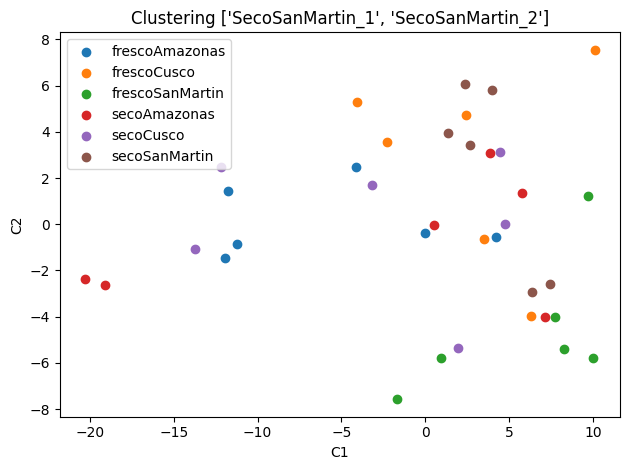

In [42]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = np.unique(labels)

for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/clustering_{encoder}_{str(train_set)}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [43]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3).fit_transform(X_scaled)

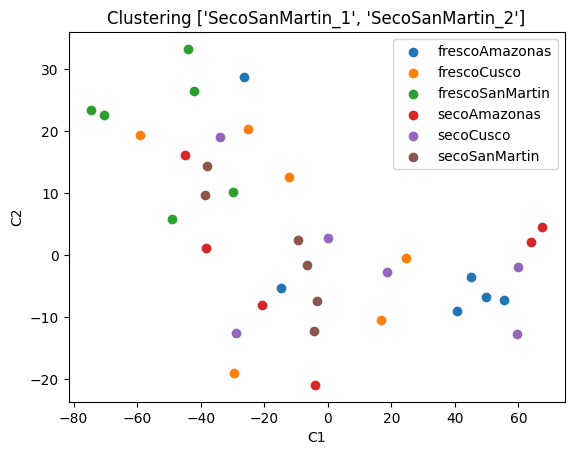

In [44]:
x, y = X_tsne[:, 0], X_tsne[:, 1]

unique_groups = np.unique(labels)

plt.figure()
for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [45]:
# import torch
# print(torch.cuda.memory_summary())